# Uncertainty-Aware Road Obstacle Identification

## 1. Imports
Import necessary libraries like PyTorch, torchvision, etc.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import Cityscapes
import numpy as np
import matplotlib.pyplot as plt
import pathlib, shutil, zipfile
from PIL import Image
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
from torch.utils.data import Subset
from random import sample
import os
from tqdm import tqdm # Import tqdm
import gc
from torch.amp import GradScaler, autocast
from itertools import islice
from IPython.display import display, clear_output
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights
import re


## 2. Globals
Define paths and device configuration

In [8]:
# Global variables
# DATASET_PATH = r"/content/drive/MyDrive/datasets/cityscapes"
LOCAL_PATH = "/content/dataset"

# Select the best available device (CPU, CUDA, or MPS (Metal Performance Shaders for macOS))
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using CUDA device: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Metal Performance Shaders) device")
else:
    device = torch.device("cpu")
    print("Using CPU")
DEVICE = device

Using CUDA device: Tesla T4


## 3. Utils
Helper functions for visualization, preprocessing, and more.

In [15]:
def unzip(zip_path, dest):
    zip_path = pathlib.Path(zip_path)
    dest = pathlib.Path(dest)
    print(f"Extracting {zip_path.name} ...")
    with zipfile.ZipFile(zip_path, 'r') as z:
        # Get the list of files in the zip for the progress bar
        file_list = z.namelist()
        # Use tqdm to wrap the iteration over the file list
        for file in tqdm(file_list, desc=f"Extracting {zip_path.name}", unit="file"):
            # Extract each file individually
            z.extract(file, dest)
    print("done!")

### Dataset reshaping

In [3]:
ID_TO_TRAINID = {
    0: 255, 1: 255, 2: 255, 3: 255, 4: 255, 5: 255, 6: 255,  # void classes
    7: 0, 8: 1, 9: 255, 10: 255,                             # road, sidewalk, parking, rail
    11: 2, 12: 3, 13: 4, 14: 255, 15: 255, 16: 255,          # construction
    17: 5, 18: 255, 19: 6, 20: 7,                            # object
    21: 8, 22: 9, 23: 10,                                    # background
    24: 11, 25: 12,                                          # human
    26: 13, 27: 14, 28: 15, 29: 255, 30: 255,                # vehicles
    31: 16, 32: 17, 33: 18                                   # train, motorcycle, bicycle
}
def convert_id_to_trainId(pil_img):
    id_mask = np.array(pil_img, dtype=np.uint8)
    train_id_mask = np.full_like(id_mask, 255)  # default to ignore

    for id_val, train_id_val in ID_TO_TRAINID.items():
        train_id_mask[id_mask == id_val] = train_id_val

    return train_id_mask

# -------------------------
# Cityscapes 19 -> 7 Groups Mapping
# Based on trainId values (NOT id!)
# -------------------------

CITYSCAPES_GROUPS = {
    'road': [0],                              # road
    'flat_nonroad': [1],                      # sidewalk
    'construction': [2, 3, 4],                # building, wall, fence
    'object': [5, 6, 7],                      # pole, traffic light, traffic sign
    'background': [8, 9, 10],                 # vegetation, terrain, sky
    'human': [11, 12],                        # person, rider
    'vehicle': list(range(13, 19)),           # car to bicycle
}

GROUP_NAMES = ['Road', 'Flat(non-road)', 'Construction', 'Object', 'Background', 'Human', 'Vehicle', 'Objectness']

CLASS_TO_GROUP = {}
for group_idx, (_, train_ids) in enumerate(CITYSCAPES_GROUPS.items()):
    for tid in train_ids:
        CLASS_TO_GROUP[tid] = group_idx

NUM_GROUPS = 7  # Last group (index 7) = Objectness

# -------------------------
# Label Conversion Function
# -------------------------

def convert_mask_to_multilabel(pil_img):
    mask_np = np.array(pil_img, dtype=np.uint8)  # trainId mask
    H, W = mask_np.shape
    label_tensor = np.zeros((NUM_GROUPS + 1, H, W), dtype=np.float32)

    for train_id, group_idx in CLASS_TO_GROUP.items():
        mask = (mask_np == train_id)
        label_tensor[group_idx][mask] = 1.0

        # Objectness: groups 2, 3, 5, 6 (Construction, Object, Human, Vehicle)
        if group_idx in [2, 3, 5, 6]:
            label_tensor[NUM_GROUPS][mask] = 1.0

    return torch.from_numpy(label_tensor)

In [ ]:
# -------------------------
# Transforms and Dataset
# -------------------------

img_tf = transforms.ToTensor()
lbl_tf = transforms.Lambda(lambda img: convert_mask_to_multilabel(Image.fromarray(convert_id_to_trainId(img))))


### Visualization

In [4]:
# -------------------------
# Visualization
# -------------------------

def visualize_sample(dataset, index=4):
    image, mask = dataset[index]
    print("----------------------------------")
    print(f"Image shape: {image.shape}")
    print(f"Mask shape: {mask.shape}")

    for i, group_name in enumerate(GROUP_NAMES):
        pixel_count = mask[i].sum().item()
        total_pixels = mask[i].numel()
        percentage = (pixel_count / total_pixels) * 100
        print(f"{group_name}: {pixel_count:.0f} pixels ({percentage:.2f}%)")
    print("----------------------------------")
    visualize_multilabel_mask(image, mask)

def visualize_multilabel_mask(image, multilabel_mask, save_path=None):
    COLORS = plt.cm.tab10.colors
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()

    img_np = image.permute(1, 2, 0).cpu().numpy()
    axes[0].imshow(img_np)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    for i in range(8):
        mask = multilabel_mask[i].cpu().numpy()
        overlay = np.zeros_like(img_np)
        color = COLORS[i % len(COLORS)]
        for c in range(3):
            overlay[..., c] = mask * color[c]
        blended = 0.5 * img_np + 0.5 * overlay
        axes[i + 1].imshow(blended)
        axes[i + 1].set_title(f'{GROUP_NAMES[i]} (sum={mask.sum():.0f})')
        axes[i + 1].axis('off')

    if len(axes) > 8:
        axes[8].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

## 4. Data
Load and preprocess datasets like Cityscapes, LostAndFound, and Fishyscapes.

### Load into VM

In [5]:
# !pip install --upgrade gdown
!gdown --folder https://drive.google.com/drive/folders/1y4g6tcvQTXXxKnFYBMMrMW76eEYVkfn3 -O dataset

Retrieving folder contents
Processing file 1Z57-f52DG7pRRXherOlHtOxF_fpIwV56 gtFine_trainvaltest.zip
Processing file 1BIKyptRYJ8DUpwa3yzqqTqfV98INgO3l leftImg8bit_trainvaltest.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1Z57-f52DG7pRRXherOlHtOxF_fpIwV56
From (redirected): https://drive.google.com/uc?id=1Z57-f52DG7pRRXherOlHtOxF_fpIwV56&confirm=t&uuid=08c789b5-b49d-4c52-941f-7bc8727fd5ab
To: /content/dataset/gtFine_trainvaltest.zip
100% 253M/253M [00:04<00:00, 54.0MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1BIKyptRYJ8DUpwa3yzqqTqfV98INgO3l
From (redirected): https://drive.google.com/uc?id=1BIKyptRYJ8DUpwa3yzqqTqfV98INgO3l&confirm=t&uuid=dbf1fc35-247d-4171-91e4-2fdb3e247461
To: /content/dataset/leftImg8bit_trainvaltest.zip
100% 11.6G/11.6G [03:06<00:00, 62.2MB/s]
Download completed


### Dataset

#### Validation set

Validation set size: 500
Validation set item shape: torch.Size([8, 1024, 2048])
----------------------------------
Image shape: torch.Size([3, 1024, 2048])
Mask shape: torch.Size([8, 1024, 2048])
Road: 785990 pixels (37.48%)
Flat(non-road): 88348 pixels (4.21%)
Construction: 421863 pixels (20.12%)
Object: 9307 pixels (0.44%)
Background: 343019 pixels (16.36%)
Human: 12128 pixels (0.58%)
Vehicle: 315786 pixels (15.06%)
Objectness: 759084 pixels (36.20%)
----------------------------------


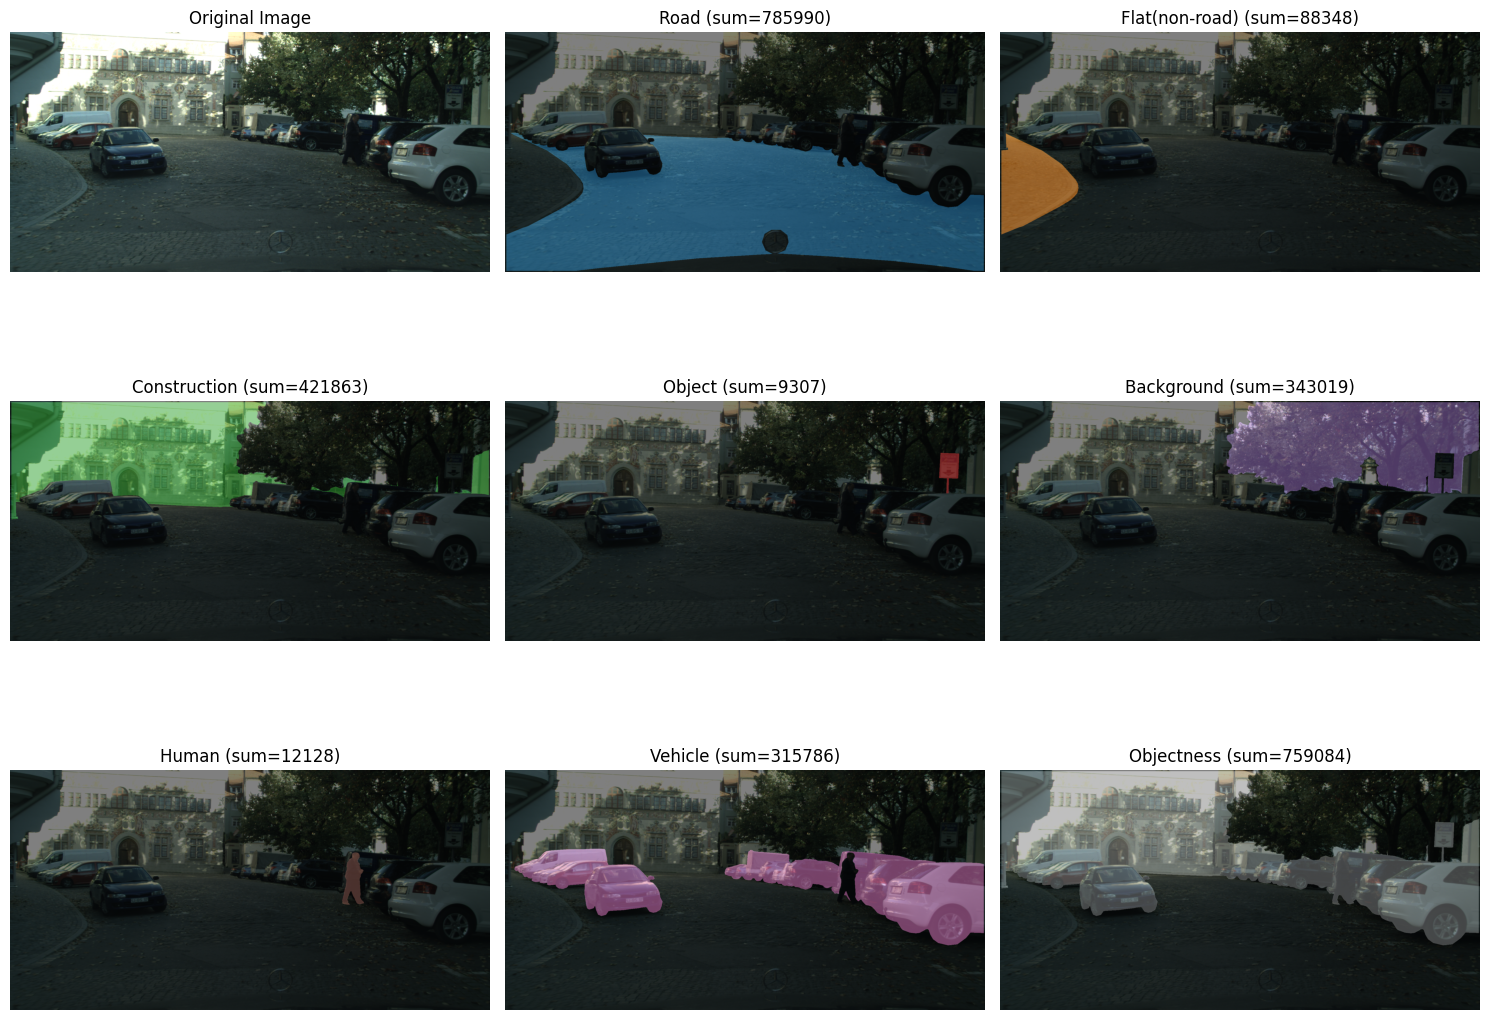

In [9]:
# ready-made dataset wrapper
val_set = Cityscapes(
    root=LOCAL_PATH,
    split = 'val',            # 500 fine labelled images
    mode='fine',              # using the accurate (not coarse) masks
    target_type ='semantic',  # we want a single channel with class-IDs
    transform=img_tf,         # apply to the RGB image
    target_transform=lbl_tf   # apply to the mask
)

print(f"Validation set size: {len(val_set)}")
print(f"Validation set item shape: {val_set[0][1].shape}")
visualize_sample(val_set, index=random.randint(0, len(val_set)))

#### Train set

In [ ]:
train_set = Cityscapes(
    root=LOCAL_PATH,
    split='train',
    mode='fine',
    target_type='semantic',
    transform=img_tf,
    target_transform=lbl_tf
)

#### Test set

In [ ]:
test_set = Cityscapes(
    root=LOCAL_PATH,
    split='test',
    mode='fine',
    target_type='semantic',  # will be ignored or return None
    transform=img_tf,
    target_transform=None
)

## 5. Unkown Object Scores Network


In [10]:
class DeepLabV3_SigmoidHead(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        # Load pretrained DeepLabV3 and remove the classifier
        backbone = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
        self.backbone_features = backbone.backbone
        self.aspp = backbone.classifier[0]  # ASPP module
        # Custom sigmoid head
        self.classifier = nn.Sequential(nn.Dropout(0.5),
                                        nn.Conv2d(256, num_classes + 1, kernel_size=1),
                                        # nn.Sigmoid() # RIGHT NOW IT IS COMMENTED AS WE WILL TRAIN USING torch.nn.BCEWithLogitsLoss
                                        )

    def forward(self, x):
        input_shape = x.shape[-2:]
        # Extract features
        features = self.backbone_features(x)
        # Apply ASPP
        x = self.aspp(features['out'])
        # Apply classifier with sigmoid
        x = self.classifier(x)
        # Upsample to input resolution
        x = nn.functional.interpolate(x, size=input_shape, mode='bilinear', align_corners=False)
        return x

## 6. Training

#### Model and objects definition

In [11]:
""" MODEL DEFINITION
  Create model for Cityscapes with 7 grouped classes + objectness
  As mentioned in the paper:
  1. "road"
  2. "flat(w/o road)"
  3. "human"
  4. "vehicle"
  5. "construction"
  6. "object"
  7. "background"
"""

LEARNING_RATE = 0.01
EPOCHS = 8
BATCH_SIZE = 3

model = DeepLabV3_SigmoidHead(num_classes=7)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 214MB/s]
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    drop_last=True
)


test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True,
    num_workers=2,
    pin_memory=True
)

In [ ]:
val_loader = torch.utils.data.DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    drop_last=True,
    num_workers=2,
    pin_memory=True
)
# ====== Create a small validation subset loader ======
VAL_SUBSET_BATCHES = 10
BATCH_SIZE = int(val_loader.batch_size)
TOTAL_VAL_SAMPLES = VAL_SUBSET_BATCHES * BATCH_SIZE

val_indices = sample(range(len(val_set)), TOTAL_VAL_SAMPLES)
val_subset = Subset(val_set, val_indices)

val_subset_loader = torch.utils.data.DataLoader(
    val_subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)


In [12]:
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:128'

def save_checkpoint(model, optimizer, scheduler, scaler, epoch, path='checkpoints/last_checkpoint.pth'):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'scaler_state_dict': scaler.state_dict(),
        'epoch': epoch
    }, path)

def load_checkpoint(model, optimizer, scheduler, scaler, path='checkpoints/last_checkpoint.pth'):
    if not os.path.exists(path):
        print("No checkpoint found at:", path)
        return 0
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    scaler.load_state_dict(checkpoint['scaler_state_dict'])
    print(f"✅ Loaded checkpoint from {path} (epoch {checkpoint['epoch']})")
    return checkpoint['epoch']


def load_weights(model, path):
    if not os.path.exists(path):
        print("No model weights found at:", path)
        return model # Return the original model if no weights are found
    # Load the state dictionary directly from the file
    state_dict = torch.load(path)
    model.load_state_dict(state_dict)
    print(f"✅ Loaded model weights from {path}")
    return model

@torch.no_grad()
def evaluate_model(model, dataloader, loss_fn, device='cuda',training = True):
    model.eval()
    total_loss = 0.0
    correct = 0
    total_pixels = 0

    # Wrap the dataloader with tqdm for a loading bar
    loop = tqdm(dataloader, desc="Evaluating", leave=False)

    for images, targets in loop:
        images = images.to(device, non_blocking=True)
        targets = targets.to(device, non_blocking=True)

        if training:
          with autocast(device_type=str(device)):
              outputs = model(images)
              loss = loss_fn(outputs, targets)
              total_loss += loss.item()
              preds = (torch.sigmoid(outputs) > 0.5).float()
              correct += (preds == targets).float().sum().item()
              total_pixels += torch.numel(targets)
        else:
          outputs = model(images)
          loss = loss_fn(outputs, targets)
          total_loss += loss.item()
          preds = (torch.sigmoid(outputs) > 0.5).float()
          correct += (preds == targets).float().sum().item()
          total_pixels += torch.numel(targets)


        del images, targets, outputs, preds, loss

        # Update tqdm description with current loss and accuracy (optional)
        loop.set_postfix(loss=total_loss/(loop.n+1), acc=correct/total_pixels)


    avg_loss = total_loss / len(dataloader)
    accuracy = correct / total_pixels
    return avg_loss, accuracy


def train_model(model, train_loader, val_loader, optimizer, loss_fn, scheduler,
                num_epochs=50, device='cuda'):
    model.to(device)
    torch.cuda.empty_cache(); gc.collect()

    scaler = GradScaler('cuda')
    best_val_loss = float('inf')
    accumulation_steps = 4

    start_epoch = load_checkpoint(model, optimizer, scheduler, scaler)

    # histories & counters
    raw_loss_history    = []   # instantaneous per-batch loss
    avg_loss_history    = []   # global running-average
    global_running_loss = 0.0
    global_total_batches = 0
    plot_every = 1

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        running_correct = 0
        total_pixels = 0

        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)
        optimizer.zero_grad()

        for batch_idx, (images, targets) in enumerate(loop):
            images = images.to(device, non_blocking=True)
            targets = targets.to(device, non_blocking=True)

            with autocast(device_type=str(device)):
                outputs = model(images)
                original_loss = loss_fn(outputs, targets)
                scaled_loss = original_loss / accumulation_steps

            scaler.scale(scaled_loss).backward()

            # update per-epoch metrics
            running_loss += original_loss.item()
            with torch.no_grad():
                preds = (torch.sigmoid(outputs) > 0.5).float()
                running_correct += (preds == targets).float().sum().item()
                total_pixels += torch.numel(targets)

            # record raw loss
            raw_loss_history.append(original_loss.item())

            # update global running average
            global_running_loss  += original_loss.item()
            global_total_batches += 1
            avg_loss_history.append(global_running_loss / global_total_batches)

            # optimizer step
            if (batch_idx + 1) % accumulation_steps == 0:
                scaler.step(optimizer); scaler.update(); optimizer.zero_grad()

            # cleanup
            del images, targets, outputs, preds, original_loss, scaled_loss
            if batch_idx % 5 == 0:
                torch.cuda.empty_cache(); gc.collect()

            # live plotting
            loop.set_postfix(loss=running_loss/(batch_idx+1))
            if batch_idx and batch_idx % plot_every == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10,4))
                # plot both curves
                plt.plot(raw_loss_history, alpha=0.3, label="Raw Batch Loss")
                plt.plot(avg_loss_history,   label="Global Running Avg")
                plt.xlabel("Global Batch #")
                plt.ylabel("Loss")
                plt.title(f"Epoch {epoch+1} Live")
                plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

        # handle leftover grads
        if (batch_idx + 1) % accumulation_steps != 0:
            scaler.step(optimizer); scaler.update(); optimizer.zero_grad()

        # epoch summary & validation
        train_loss = running_loss / len(train_loader)
        train_acc  = running_correct / total_pixels
        print('Evaluating epoch:')
        val_loss, val_acc = evaluate_model(model, val_loader, loss_fn, device)
        print(f"Epoch {epoch+1}: "
              f"Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
              f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")

        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print("✔️ Saved new best model.")
        save_checkpoint(model, optimizer, scheduler, scaler, epoch+1)
        torch.save(model.state_dict(), f'checkpoints/epoch_{epoch+1}.pth')
        torch.cuda.empty_cache(); gc.collect()

    print("Training complete.")

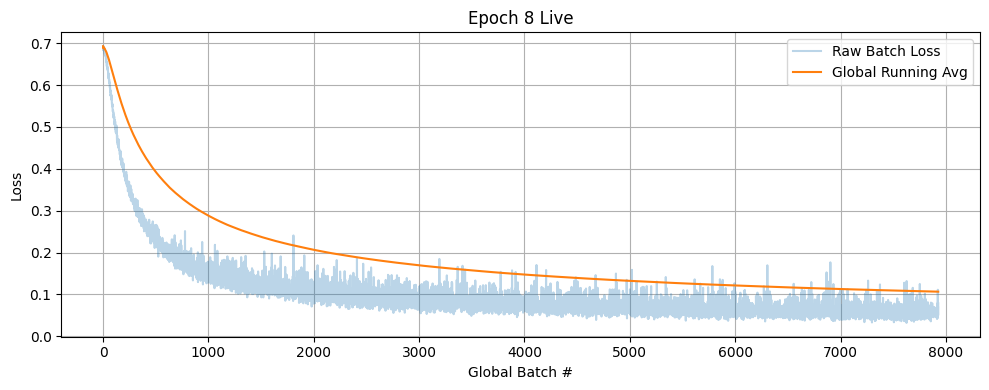

Evaluating epoch:


Epoch 8: Train Loss=0.0588, Train Acc=0.9797, Val Loss=0.0495, Val Acc=0.9819
✔️ Saved new best model.
Training complete.


In [ ]:
train_model(model, train_loader, val_subset_loader, optimizer, loss_fn, scheduler, num_epochs=EPOCHS, device=DEVICE)

In [ ]:
!rm -rf checkpoints


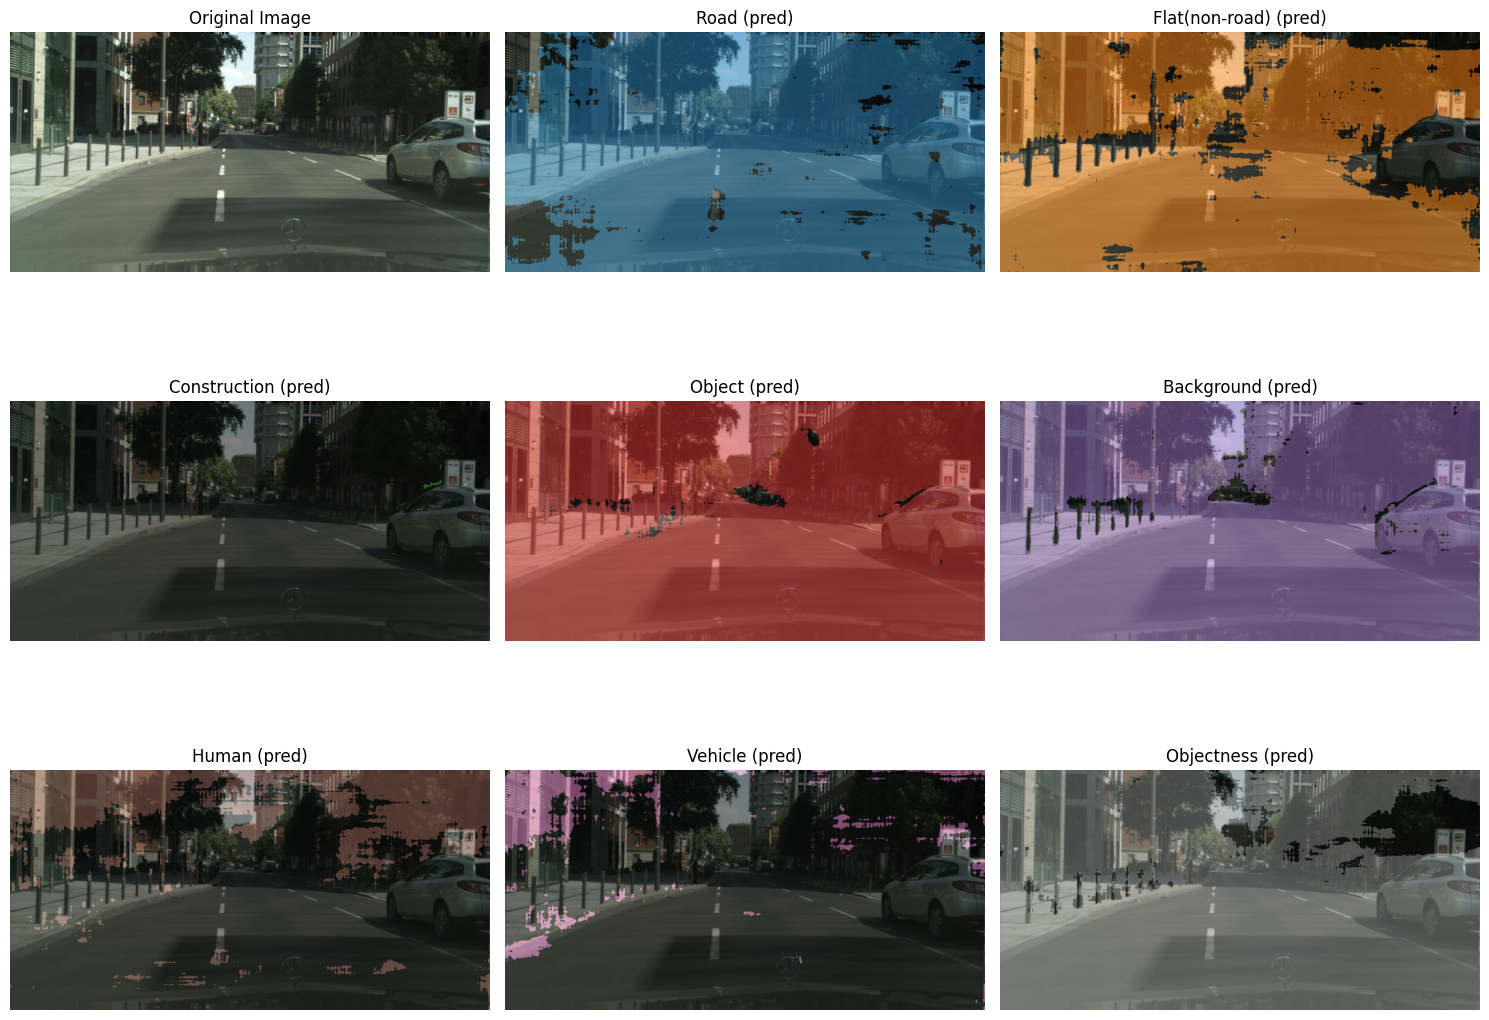

In [14]:
#@title Visualize Predictions
import random
import torch
import matplotlib.pyplot as plt
import numpy as np

# Pick a random index from the val set
idx = random.randint(0, len(val_set) - 1)
image, true_mask = val_set[idx]  # image: [3,H,W], true_mask: [8,H,W]

# Move image to batch form and to GPU
model.eval()
model.to(DEVICE)
with torch.no_grad():
    input_tensor = image.unsqueeze(0).to(DEVICE)  # [1,3,H,W]
    output = model(input_tensor)                 # [1,8,H,W]
    pred_mask = torch.sigmoid(output).squeeze(0).cpu()  # [8,H,W]

# Visualize prediction vs ground truth
def visualize_prediction(image, pred_mask, true_mask=None):
    COLORS = plt.cm.tab10.colors
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()

    img_np = image.permute(1, 2, 0).cpu().numpy()
    axes[0].imshow(img_np)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    for i in range(8):
        mask = (pred_mask[i] > 0.5).float().numpy()
        overlay = np.zeros_like(img_np)
        color = COLORS[i % len(COLORS)]
        for c in range(3):
            overlay[..., c] = mask * color[c]
        blended = 0.5 * img_np + 0.5 * overlay
        axes[i + 1].imshow(blended)
        axes[i + 1].set_title(f'{GROUP_NAMES[i]} (pred)')
        axes[i + 1].axis('off')

    if len(axes) > 8:
        axes[8].axis('off')

    plt.tight_layout()
    plt.show()

# Call it
visualize_prediction(image, pred_mask, true_mask)

#Model Validation

In [19]:
#@title  Download Weight Checkpoints
# !pip install --upgrade gdown
!gdown --folder https://drive.google.com/drive/folders/1X_sie38bSouwjZVhEQQuzjMd5YJ0Lht9 -O dataset

Retrieving folder contents
Processing file 1QDhjZLN1QLsndlibQu2m9_UjStzBqg8z model_weights.zip
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1QDhjZLN1QLsndlibQu2m9_UjStzBqg8z
From (redirected): https://drive.google.com/uc?id=1QDhjZLN1QLsndlibQu2m9_UjStzBqg8z&confirm=t&uuid=caff9d1c-7636-4d42-bd30-2fdf0a3873e3
To: /content/dataset/model_weights.zip
100% 2.03G/2.03G [00:33<00:00, 60.1MB/s]
Download completed


In [20]:
#@title Checkpoints weights validation

#Unzip weights and put them in a list
zippath = pathlib.Path('/content/dataset/model_weights.zip')
DEST_W_PATH = pathlib.Path("/content/dataset/weights")
unzip(zippath, DEST_W_PATH)
# zippath.unlink()  #delete zip file
print("ZIP files extracted and deleted")

Extracting model_weights.zip ...


Extracting model_weights.zip: 100%|██████████| 26/26 [00:15<00:00,  1.63file/s]

done!
ZIP files extracted and deleted


In [24]:
#Load weights to model
folder_path = '/content/dataset/weights'
file_list = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

# # Sort the file_list
sorted_file_list = sorted(file_list)
avg_loss_list = []
accuracy_list = []
for item_name in sorted_file_list:
  if item_name == "last_checkpoint.pth":
    pass
  else:
    item_path = os.path.join(folder_path, item_name)
    model.to(DEVICE)
    model_loaded = load_weights(model,item_path)
    #Evaluate model using original val_loader
    avg_loss, accuracy = evaluate_model(model_loaded, val_loader, loss_fn,training = False)
    print(f"Epoch: {item_name}, Average Loss: {avg_loss}, Accuracy: {accuracy}")
    avg_loss_list.append(avg_loss)
    accuracy_list.append(accuracy)

sorted_file_list.remove("last_checkpoint.pth")

✅ Loaded model weights from /content/dataset/weights/epoch_1.pth


Epoch: epoch_1.pth, Average Loss: 0.13960189497973546, Accuracy: 0.9587388048210297
✅ Loaded model weights from /content/dataset/weights/epoch_2-2.pth


Epoch: epoch_2-2.pth, Average Loss: 0.09268817404307515, Accuracy: 0.9681694234710142
✅ Loaded model weights from /content/dataset/weights/epoch_2.pth


Epoch: epoch_2.pth, Average Loss: 0.09257062641252954, Accuracy: 0.9691709141175909
✅ Loaded model weights from /content/dataset/weights/epoch_3-2.pth


Epoch: epoch_3-2.pth, Average Loss: 0.07583119064928537, Accuracy: 0.9735509042280266
✅ Loaded model weights from /content/dataset/weights/epoch_3.pth


Epoch: epoch_3.pth, Average Loss: 0.07641109036483679, Accuracy: 0.9738489178768602
✅ Loaded model weights from /content/dataset/weights/epoch_4-2.pth


Epoch: epoch_4-2.pth, Average Loss: 0.06780814121376319, Accuracy: 0.9752477800032221
✅ Loaded model weights from /content/dataset/weights/epoch_4.pth


Epoch: epoch_4.pth, Average Loss: 0.06871104215731821, Accuracy: 0.975499322136722
✅ Loaded model weights from /content/dataset/weights/epoch_5-2.pth


Epoch: epoch_5-2.pth, Average Loss: 0.061302398701748216, Accuracy: 0.9774111897112375
✅ Loaded model weights from /content/dataset/weights/epoch_5.pth


Epoch: epoch_5.pth, Average Loss: 0.06292924828019487, Accuracy: 0.9765713885127301
✅ Loaded model weights from /content/dataset/weights/epoch_6.pth


Epoch: epoch_6.pth, Average Loss: 0.05775925541767873, Accuracy: 0.9785331492443161
✅ Loaded model weights from /content/dataset/weights/epoch_7.pth


Epoch: epoch_7.pth, Average Loss: 0.054950101458164584, Accuracy: 0.9796681294000771
✅ Loaded model weights from /content/dataset/weights/epoch_8.pth


Epoch: epoch_8.pth, Average Loss: 0.05319542243672782, Accuracy: 0.9801704744737311


In [34]:
checkpoint = torch.load('/content/dataset/weights/last_checkpoint.pth')
model = load_checkpoint
model.load_state_dict(checkpoint['model_state_dict'])
avg_loss, accuracy = evaluate_model(model, val_loader, loss_fn,training = False)
print(f"Epoch: last, Average Loss: {avg_loss}, Accuracy: {accuracy}")
avg_loss_list.append(avg_loss)
accuracy_list.append(accuracy)
sorted_file_list.append("epoch_last.pth")

Epoch: last, Average Loss: 0.13960189497973546, Accuracy: 0.9587388048210297


In [42]:
epochs = [re.search(r'epoch_(.+)\.pth', e).group(1) for e in sorted_file_list]
epochs.append('last')
print(epochs)

['1', '2-2', '2', '3-2', '3', '4-2', '4', '5-2', '5', '6', '7', '8', 'last']


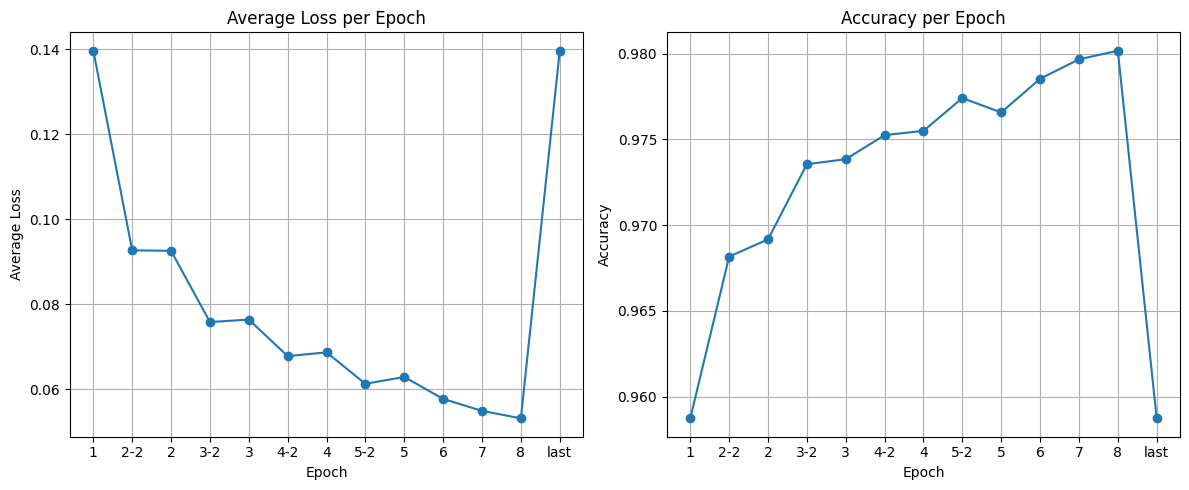

In [43]:
plt.figure(figsize=(12, 5))
# Plot Average Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, avg_loss_list, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Loss per Epoch")
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_list, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.grid(True)

plt.tight_layout()
plt.show()

#Unknown Object Score

In [16]:
# Pick a random index from the val set
idx = random.randint(0, len(val_set) - 1)
image, true_mask = val_set[idx]  # image: [3,H,W], true_mask: [8,H,W]



# Move image to batch form and to GPU
model.eval()
model.to(DEVICE)
with torch.no_grad():
    input_tensor = image.unsqueeze(0).to(DEVICE)  # [1,3,H,W]

    output = model(input_tensor)                 # [1,8,H,W]
    pred_mask = torch.sigmoid(output).squeeze(0).cpu()  # [8,H,W]

    known_class_probs = pred_mask[:7,:,:] # Shape: [7, H, W]
    inv_known_class_probs = 1 - known_class_probs
    inv_probs_product = torch.prod(inv_known_class_probs, dim=0) # Shape: [H, W]
    objectness_scores = pred_mask[7,:,:] # Shape: [H, W]

    unk_obj_score = inv_probs_product * objectness_scores # Shape: [H, W]
    print(unk_obj_score[1][1])

tensor(0.0039)
